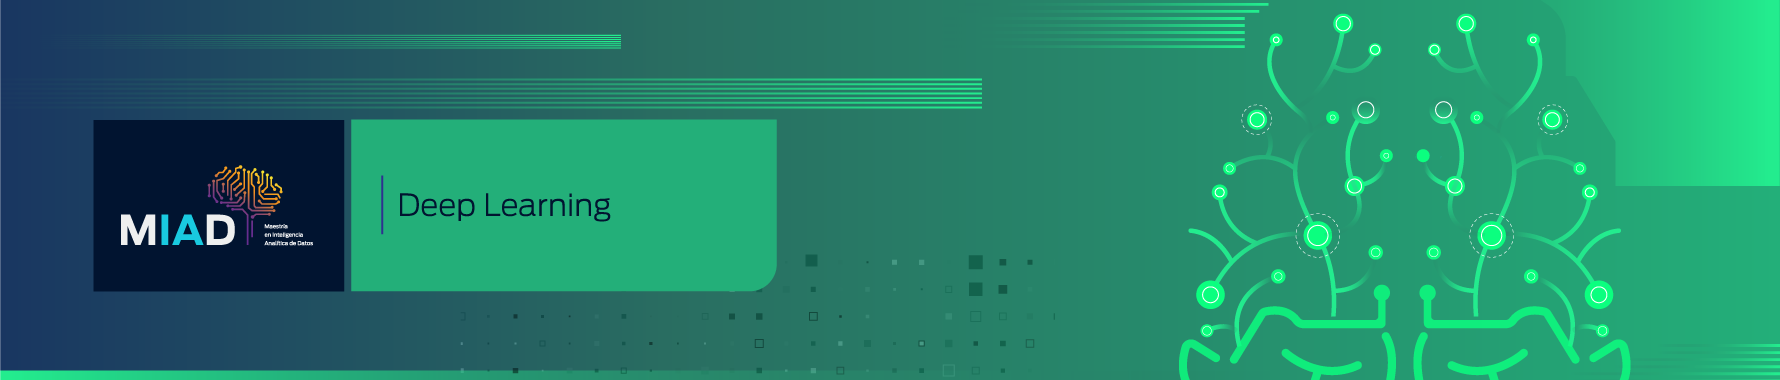

# Introducción a Redes Convolucionales

## Implementación de Redes Convolucionales en Keras
### Propósito 

En este notebook implementaremos de manera general una red convolucional sobre la base de datos de dígitos manuscritos de MNIST utilizando funciones de la librería `keras`. 

### Instrucciones generales

1. Para realizar la actividad solo siga las indicaciones asociadas a cada celda del notebook. Sin embargo, siéntase libre de modificar el archivo editando las celdas, lo que le permitirá afianzar su comprensión sobre las distintas funcionalidades de código.  

2. Recuerde que para esta actividad NO necesita realizar ningún tipo de entrega.

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [1]:
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
#Las siguientes dos líneas evitan la generación de "warnings" y "flags" al importar keras y tensorflow.
#Dichas advertencias no comprometen el funcionamiento del código.
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#Importación de keras y tensorflow
import keras
import tensorflow as tf
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import AveragePooling2D

### Preparación de los datos
En primer lugar, cargaremos los datos a usar en este Notebook que corresponden a la base de datos de dígitos manuscritos de MNIST disponibles en el paquete `tensorflow-keras`. La base de datos está dividida originalmente en una sección de train y otra de test de la siguiente manera:

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Las imágenes estan codificadas como arreglos de numpy, y los labels son un arreglo de digitos de 0 a 9. Las imágenes y los labels tienen una correspondencia uno a uno. 

In [3]:
print('Dimensiones de los datos de Training: ', x_train.shape, y_train.shape)
print('Dimensiones de los datos de Testing: ', x_test.shape, y_test.shape)

Dimensiones de los datos de Training:  (60000, 28, 28) (60000,)
Dimensiones de los datos de Testing:  (10000, 28, 28) (10000,)


In [4]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Número total de clases: ', nClasses)
print('Clases/labels: ', classes)

Número total de clases:  10
Clases/labels:  [0 1 2 3 4 5 6 7 8 9]


Visualizemos algunas de las imágenes de cada conjunto de datos.

Text(0.5, 1.0, 'Label : 7')

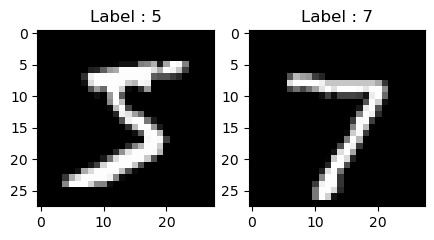

In [5]:
plt.figure(figsize=[5,5])
# Visualiza la primera imagen en la base de training
plt.subplot(121)
plt.imshow(x_train[0,:,:], cmap='gray')
plt.title("Label : {}".format(y_train[0]))

# Visualiza la primera imagen en la base de testing
plt.subplot(122)
plt.imshow(x_test[0,:,:], cmap='gray')
plt.title("Label : {}".format(y_test[0]))

Ahora, transformamos el formato de los datos de entero a número real y luego escalamos el valor de los pixeles de manera que queden variando entre 0 y 1.

In [6]:
train_X = x_train.astype('float32')
test_X = x_test.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Ahora subdividimos los datos de entrenamiento para obtener los datos requeridos para la calibración de pesos de la red y los datos de validación. Para este notebook, use el valor indicado de `random_state` para hacer reproducibles los resultados del ejercicio.

In [7]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, y_train, test_size=0.2, random_state=1324)
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 28, 28), (12000, 28, 28), (48000,), (12000,))

En estas líneas de texto, ajustamos las dimensiones de los datos para que puedan ser trabajadas por las funciones de `keras`. 

In [8]:
image_rows = train_X.shape[1]
image_cols = train_X.shape[2]
train_X = train_X.reshape(-1,image_rows,image_cols, 1)
test_X = test_X.reshape(-1,image_rows,image_cols, 1)
train_X.shape, test_X.shape

((48000, 28, 28, 1), (10000, 28, 28, 1))

La red convolucional básica que implementaremos se puede resumir en el siguiente esquema:

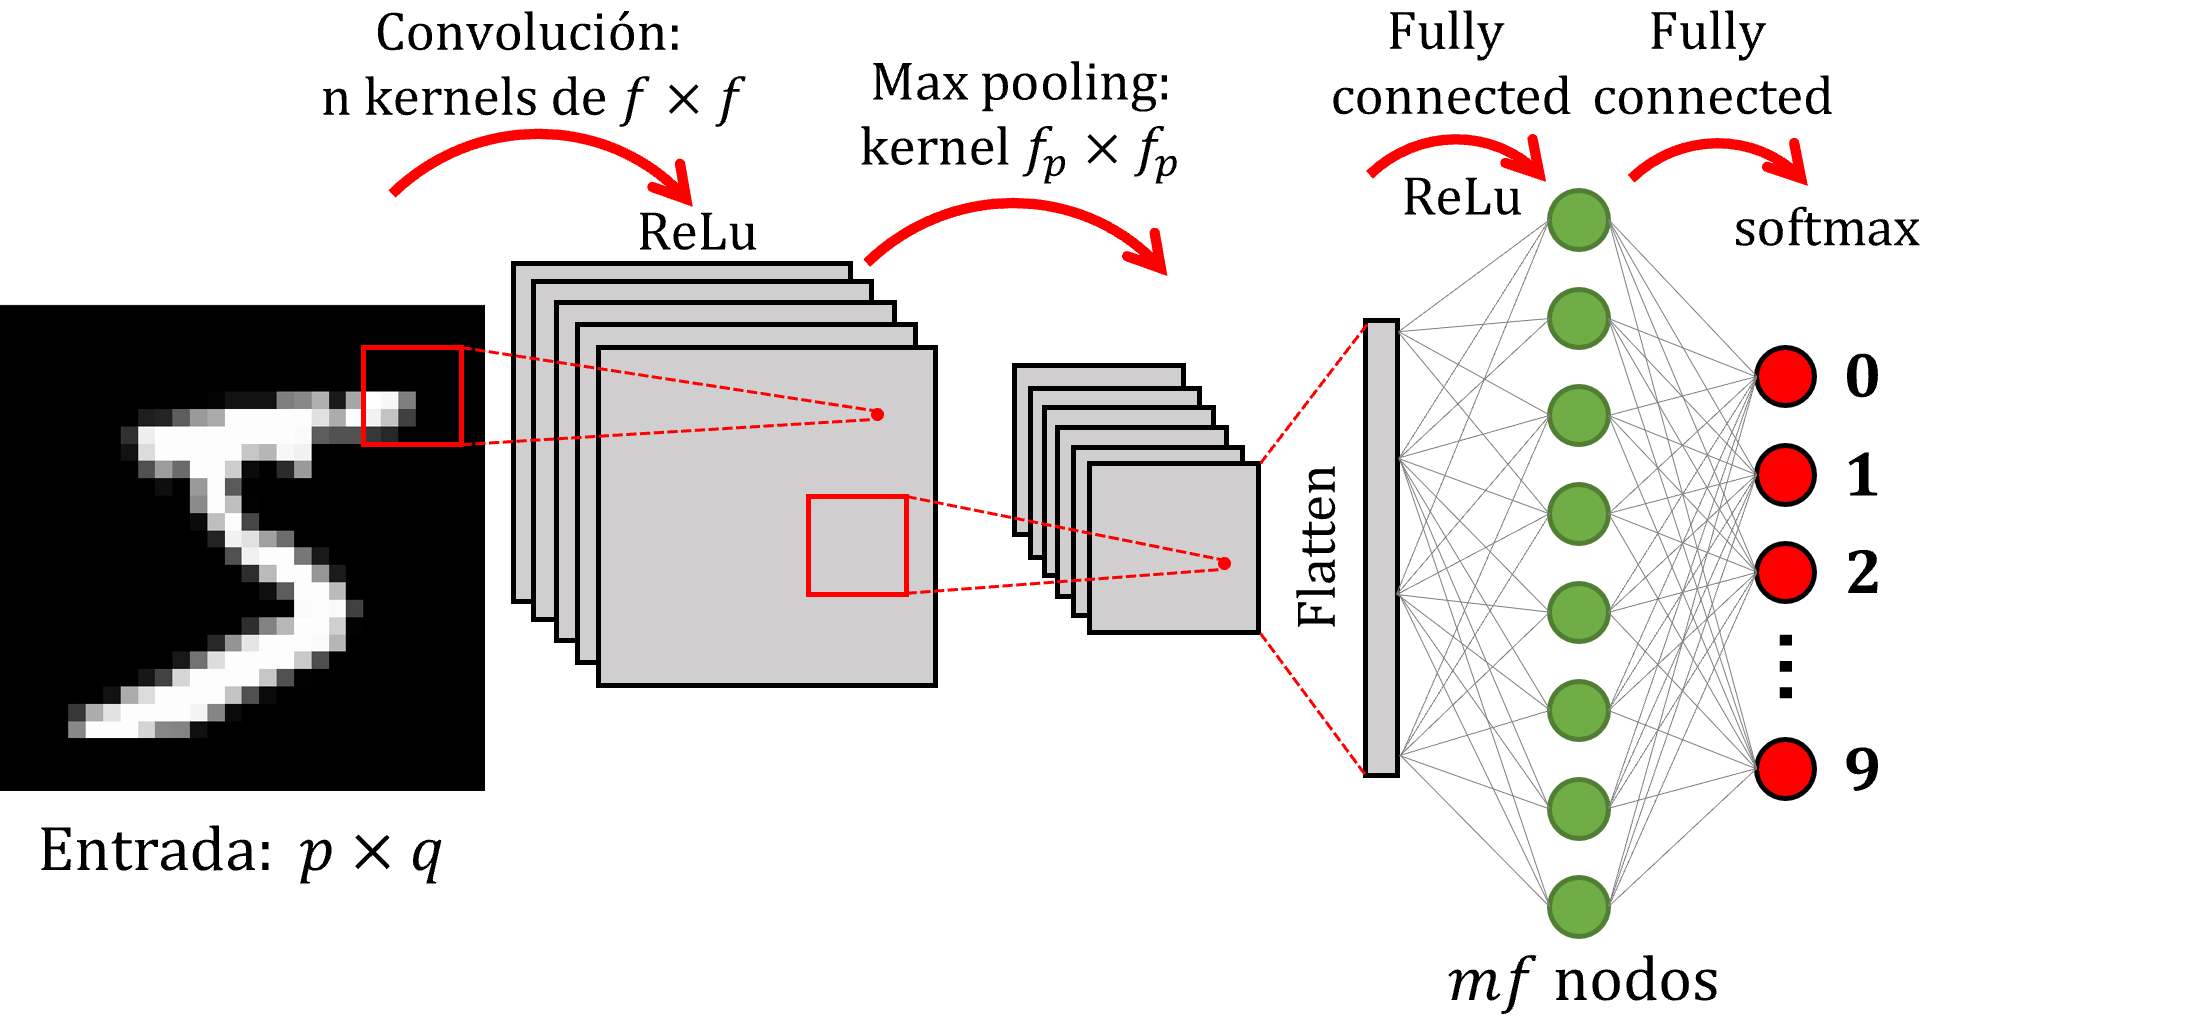

Para construir este modelo de redes neuronales convolucionales aplicaremos:
*   Una convolución con 32 matrices de $3\times 3$ con función de activación ReLu y padding de modo que se garantice que la salida de esta capa tenga las mismas dimensiones de la información de entrada.
*   Una capa de Maximum Pooling con matrices de $2\times 2$.
*   Una capa de Dropout.
*   Una capa de Flatten, que reorganiza los datos para ser entregados a una capa totalmente conectada (Dense) de 64 nodos con activación ReLu.
*   Una capa para la clasificación utilizando activación SoftMax.

In [9]:
digits_model = Sequential()
digits_model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(image_rows,image_cols,1),padding='same'))
digits_model.add(MaxPooling2D((2, 2),padding='same'))
digits_model.add(Dropout(0.2))
digits_model.add(Flatten())
digits_model.add(Dense(64, activation='relu'))               
digits_model.add(Dense(nClasses, activation='softmax'))

Se especifica la función de pérdida, el optimizador y la métrica a revisar durante el ajuste del modelo.

In [10]:
digits_model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics =['accuracy'])
digits_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 64)                401472    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                        

Entrenamos el modelo con los siguientes valores propuestos para las épocas y el tamaño de batch (tenga en cuenta que el ajuste de este modelo toma alrededor de 20 minutos con estas condiciones):

In [11]:
batch_size = 4800
epochs = 25
digits_train = digits_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/25
10/10 [==============================] - 31s 3s/step - loss: 0.9733 - accuracy: 0.6744 - val_loss: 0.3571 - val_accuracy: 0.8979
Epoch 2/25
10/10 [==============================] - 29s 3s/step - loss: 0.2969 - accuracy: 0.9146 - val_loss: 0.2141 - val_accuracy: 0.9375
Epoch 3/25
10/10 [==============================] - 29s 3s/step - loss: 0.1787 - accuracy: 0.9470 - val_loss: 0.1450 - val_accuracy: 0.9574
Epoch 4/25
10/10 [==============================] - 29s 3s/step - loss: 0.1217 - accuracy: 0.9642 - val_loss: 0.1097 - val_accuracy: 0.9682
Epoch 5/25
10/10 [==============================] - 30s 3s/step - loss: 0.0889 - accuracy: 0.9731 - val_loss: 0.0918 - val_accuracy: 0.9753
Epoch 6/25
10/10 [==============================] - 29s 3s/step - loss: 0.0722 - accuracy: 0.9784 - val_loss: 0.0788 - val_accuracy: 0.9772
Epoch 7/25
10/10 [==============================] - 30s 3s/step - loss: 0.0586 - accuracy: 0.9825 - val_loss: 0.0738 - val_accuracy: 0.9784
Epoch 8/25
10/10 [==

Con las siguientes gráficas, podemos verificar la evolución del ajuste modelo a través de las épocas.

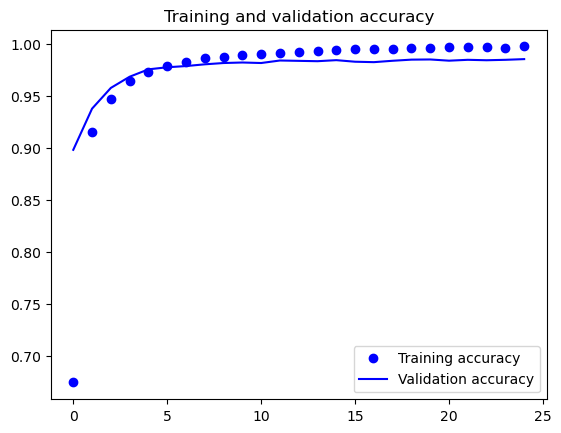

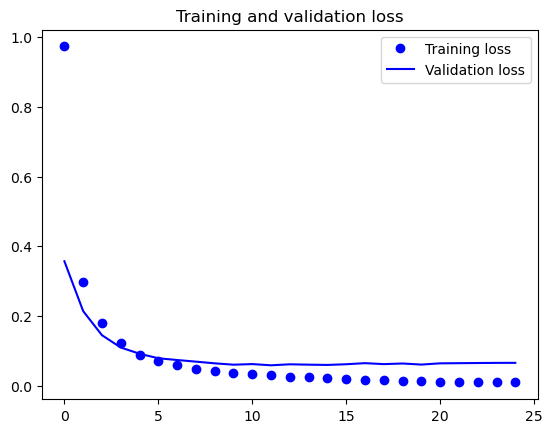

In [12]:
accuracy = digits_train.history['accuracy']
val_accuracy = digits_train.history['val_accuracy']
loss = digits_train.history['loss']
val_loss = digits_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Con nuestro modelo ajustado, podemos revisar el valor de la función de pérdida y la precisión sobre los datos de prueba (test):

In [13]:
test_eval = digits_model.evaluate(test_X, y_test, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.04950840398669243
Test accuracy: 0.9851999878883362


Finalmente, podemos verificar qué tantos labels fueron correctamente predichos y visualizar algunas predicciones a modo de ilustración:

313/313 [==============================] - 13s 5ms/step
Se encontraron 9850 labels correctos


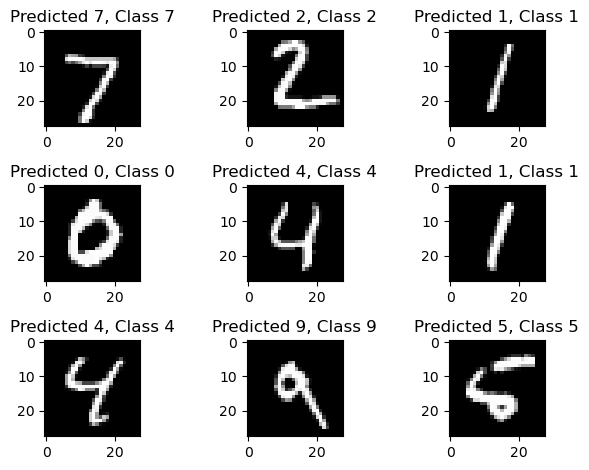

In [14]:
predicted_classes = digits_model.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
correct = np.where(predicted_classes==y_test)[0]
test="Se encontraron %s labels correctos" % len(correct)
print(test) 
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
plt.tight_layout()

### Actividad individual no evaluada: Probando varias arquitecturas

Con la red convolucional simple que realizamos anteriormente obtuvimos un _accuracy_ bastante aceptable (alrededor de 98 %), sin embargo se podría mejorar. Algunas sugerencias que pueden servir para una arquitectura con mejor desempeño y que puede probar serían:
*   Cambiar el número de kernels de la convolución y la función de activación de esa capa.
*   Explore la técnica Average Pooling y si hay alguna diferencia o mejora significativa.
*   El valor del `dropout` le puede ayudar a mejorar la convergencia de la red.
*   Pruebe con capas sucesivas adicionales de Convolución -> Pooling -> Dropout, esto le ayuda a tener una red más compleja pero a la vez consistente con el concepto de una red convolucional.
*   Cambie el número de nodos de la capa totalmente conectada así como la función de activación. Una capa de dropout adicional le puede ayudar a mejorar la convergencia de su algoritmo.